In [1]:
import lightning
from src.models.ae_module_allclasses import AELitModule
from src.models.components.unetmobv2 import UNetMobV2
import torch
from torch import nn as nn
import torchvision
from typing import List
from glob import glob
import random
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

/home/liujie/miniconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.14 (you have 1.4.12). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
np.random.seed(42)

In [3]:
def pasteImages(images:List[np.ndarray]):
    """
    将两张图片粘贴在一起
    """
    widths = [img.shape[1] for img in images]
    heights = [img.shape[0] for img in images]
    width = sum(widths)
    height = max(heights)
    paste_img = Image.new('RGB',(width,height))
    offset_x = 0
    for img in images:
        pil_img = Image.fromarray(img)
        paste_img.paste(pil_img,(offset_x, 0))
        offset_x += img.shape[1]
    return np.array(paste_img)

def give_colors_to_mask(image:np.ndarray, mask:np.ndarray,num_classes=6):
    image_tensor = torch.tensor(image).permute(2,0,1)
    masks = [mask == v for v in range(num_classes)]
    mask = np.stack(masks,axis=0).astype('bool')
    mask_tensor = torch.tensor(mask)
    colors = [
    "#ffffff",  # 白色    荒地
    "#a8d5ba",  # 浅绿    低覆盖度
    "#6cc551",  # 中浅绿   中低覆盖度
    "#4caf50",  # 中绿     中覆盖度
    "#388e3c",  # 中深绿    中高覆盖度
    "#1b5e20"   # 深绿     高覆盖度
    ]

    mask_colors = torchvision.utils.draw_segmentation_masks(image_tensor,mask_tensor,colors=colors,alpha=1.0).permute(1,2,0).numpy().astype(np.uint8)
    return mask_colors

In [4]:
model = UNetMobV2(num_classes=6).to(device)

In [5]:
weights = torch.load("../logs/train/runs/2024-08-18_18-42-22/checkpoints/epoch_031.ckpt",map_location=device)['state_dict']

In [6]:
state_dict = {}
for key,value in weights.items():
    key = key[4:]
    state_dict[key] = value

In [7]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [8]:
filenames = glob("../data/grass/img/*")
filenames[:3]

['../data/grass/img/570.tif',
 '../data/grass/img/896.tif',
 '../data/grass/img/1485.tif']

In [9]:
choice_files = random.choices(filenames,k=50)
choice_files[:5]

['../data/grass/img/554.tif',
 '../data/grass/img/313.tif',
 '../data/grass/img/1581.tif',
 '../data/grass/img/200.tif',
 '../data/grass/img/341.tif']

In [10]:
images = None
for filename in choice_files:
    img = Image.open(filename)
    img = np.array(img)
    img = np.transpose(img,(2,1,0))
    img = img[np.newaxis]
    if images is None:
        images = img
    else:
        images = np.concatenate((images,img),axis=0)
images.shape

(50, 3, 256, 256)

In [11]:
x = torch.tensor(images,dtype=torch.float32,device=device) / 255.

In [12]:
logits = model(x)
preds = torch.argmax(logits,dim=1)
preds.shape

torch.Size([50, 256, 256])

In [13]:
pred_masks = preds.cpu().numpy()
pred_masks.shape

(50, 256, 256)

In [14]:
show_images = None
for idx, filename in enumerate(choice_files):
    image = np.array(Image.open(filename))

    true_mask_path = filename.replace("img","mask").replace("tif","png")
    true_mask = Image.open(true_mask_path)
    true_mask = np.array(true_mask)
    color_true_mask = give_colors_to_mask(image,true_mask)

    pred_mask = pred_masks[idx]
    color_pred_mask = give_colors_to_mask(image,pred_mask)
    show_image = pasteImages([image,color_true_mask,color_pred_mask])
    paste_img = np.transpose(show_image,(2,0,1))[np.newaxis]
    if show_images is None:
        show_images = paste_img
    else:
        show_images = np.concatenate((show_images,paste_img),axis=0)
show_images.shape

(50, 3, 256, 768)

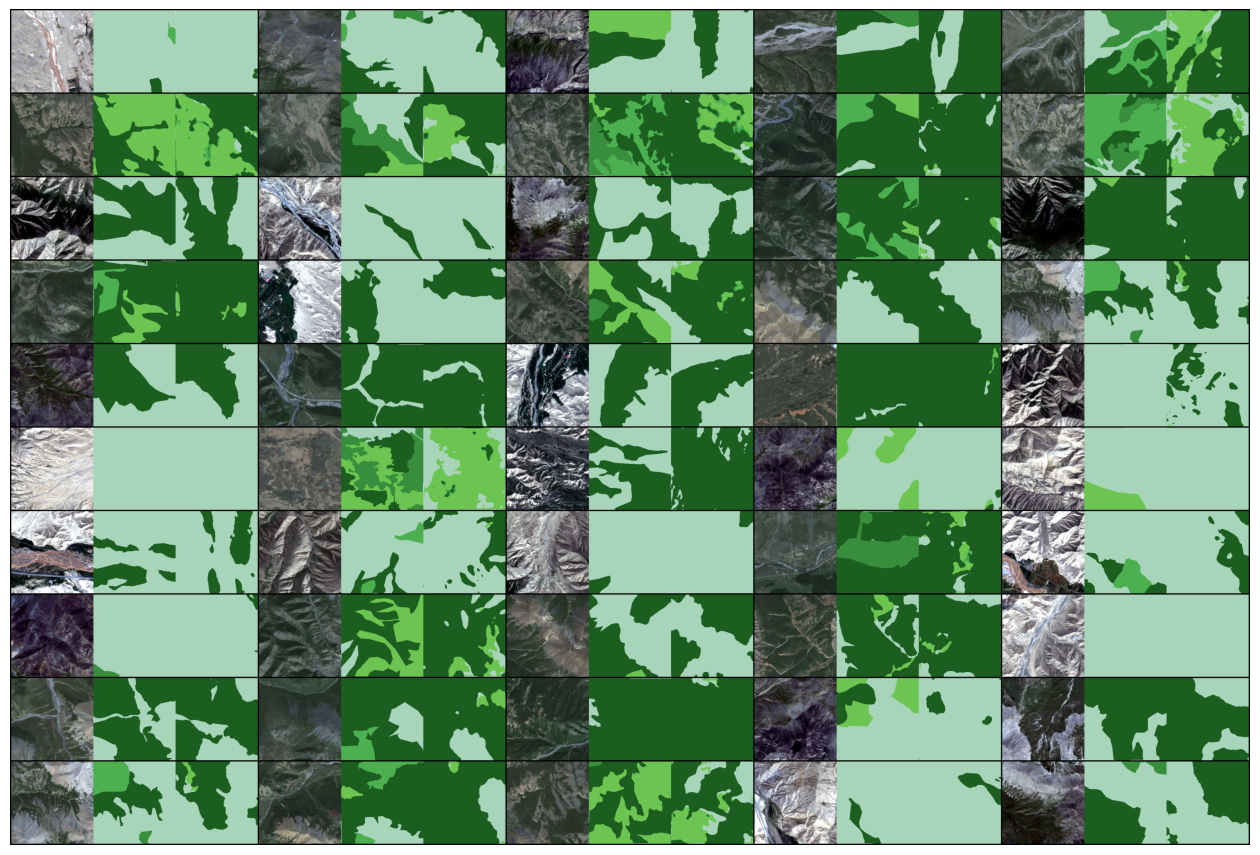

In [15]:
show_image = torch.tensor(show_images,device=device)
show_image = torchvision.utils.make_grid(show_image,nrow=5,padding=4)
plt.figure(figsize=(16,12))
plt.axis("off")
plt.imshow(show_image.permute(1,2,0).cpu().numpy())
plt.show()